# Check spinup day

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from abc import ABC, abstractclassmethod
from EOF import EOF
from scipy.fftpack import fft,ifft,fftfreq
import datetime 

In [19]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        self.p_half  = self.getVar("grid_p_half_xyzt")

        self.qv = self.getVar("grid_tracers_c_xyz1t")
        self.t_eq = self.getVar("grid_t_eq_xyzt")
        # self.grid_t_eq_ref_xyzt = self.getVar("grid_t_eq_ref_xyzt")
        # self.unsaturated = self.getVar("unsaturated_n_xyzt")
        self.add_water   = self.getVar("add_water_xyzt")
        self.rho = self.getVar("rho_xyzt")
        
        self.qv_diff = self.getVar("grid_tracers_diff_xyz1t")
        self.omega   = self.getVar("grid_w_full_xyzt")
        self.z       = self.getVar("grid_z_full_xyzt")
        self.factor1 = self.getVar("factor1_xyzt")
        self.factor2 = self.getVar("factor2_xyzt")

        self.K_E = self.getVar("K_E_xyzt")
        self.pqpz = self.getVar("pqpz_xyzt")

        
        
        self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        self.Uzm   = np.nanmean(self.u, axis=3)
        self.Vzm   = np.nanmean(self.v, axis=3)
        self.THzm  = np.nanmean(self.theta, axis=3)
        self.Pzm   = np.nanmean(self.p, axis=3)
        self.Tzm   = np.nanmean(self.t, axis=3)
        
        ### anamoly
        self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        self.THzmtm = np.nanmean(self.THzm, axis=0)
        self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        self.Vza     = np.zeros(self.u.shape)
        self.Uza     = np.zeros(self.u.shape)
        self.THETAza = np.zeros(self.u.shape)
        self.Pza     = np.zeros(self.u.shape)
        self.Tza     = np.zeros(self.t.shape)

        for i in range(0,128):
            self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
            self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
            self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
            self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
            self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan

    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def cal_KE(self):
        self.KE = (self.u**2 + self.v**2)
        self.KE_mean = np.nanmean(self.KE, axis=(1,3))
        return self.KE_mean
    
    def cal_pre(self):
        self.Prec = np.zeros(self.u.shape)
        for i in range(1,20-1):
            self.Prec[:,i,:,:] = 1/self.g * self.qv_diff[:,i,:,:] * (self.p[:,i+1,:,:] - self.p[:,i-1,:,:])/2
        self.Prec[:, 0,:,:] = 1/self.g * self.qv_diff[:, 0,:,:] * (self.p[:, 1,:,:] - self.p[:, 0,:,:])/2
        self.Prec[:,-1,:,:] = 1/self.g * self.qv_diff[:,-1,:,:] * (self.p[:,-1,:,:] - self.p[:,-2,:,:])/2
        
        self.Prec_mean = np.nanmean(self.Prec, axis=(1))
        self.Prec_mean2 = np.nanmean(self.Prec_mean, axis=(2))
        
        return self.Prec_mean2
    
    def cal_t(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_t_last(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[-100:,:,:,:], axis=(1,3))
        return self.t_mean

In [20]:
time = np.linspace(0,2,2)
y    = np.linspace(-90,90,64)

yy, tt = np.meshgrid(y,time)

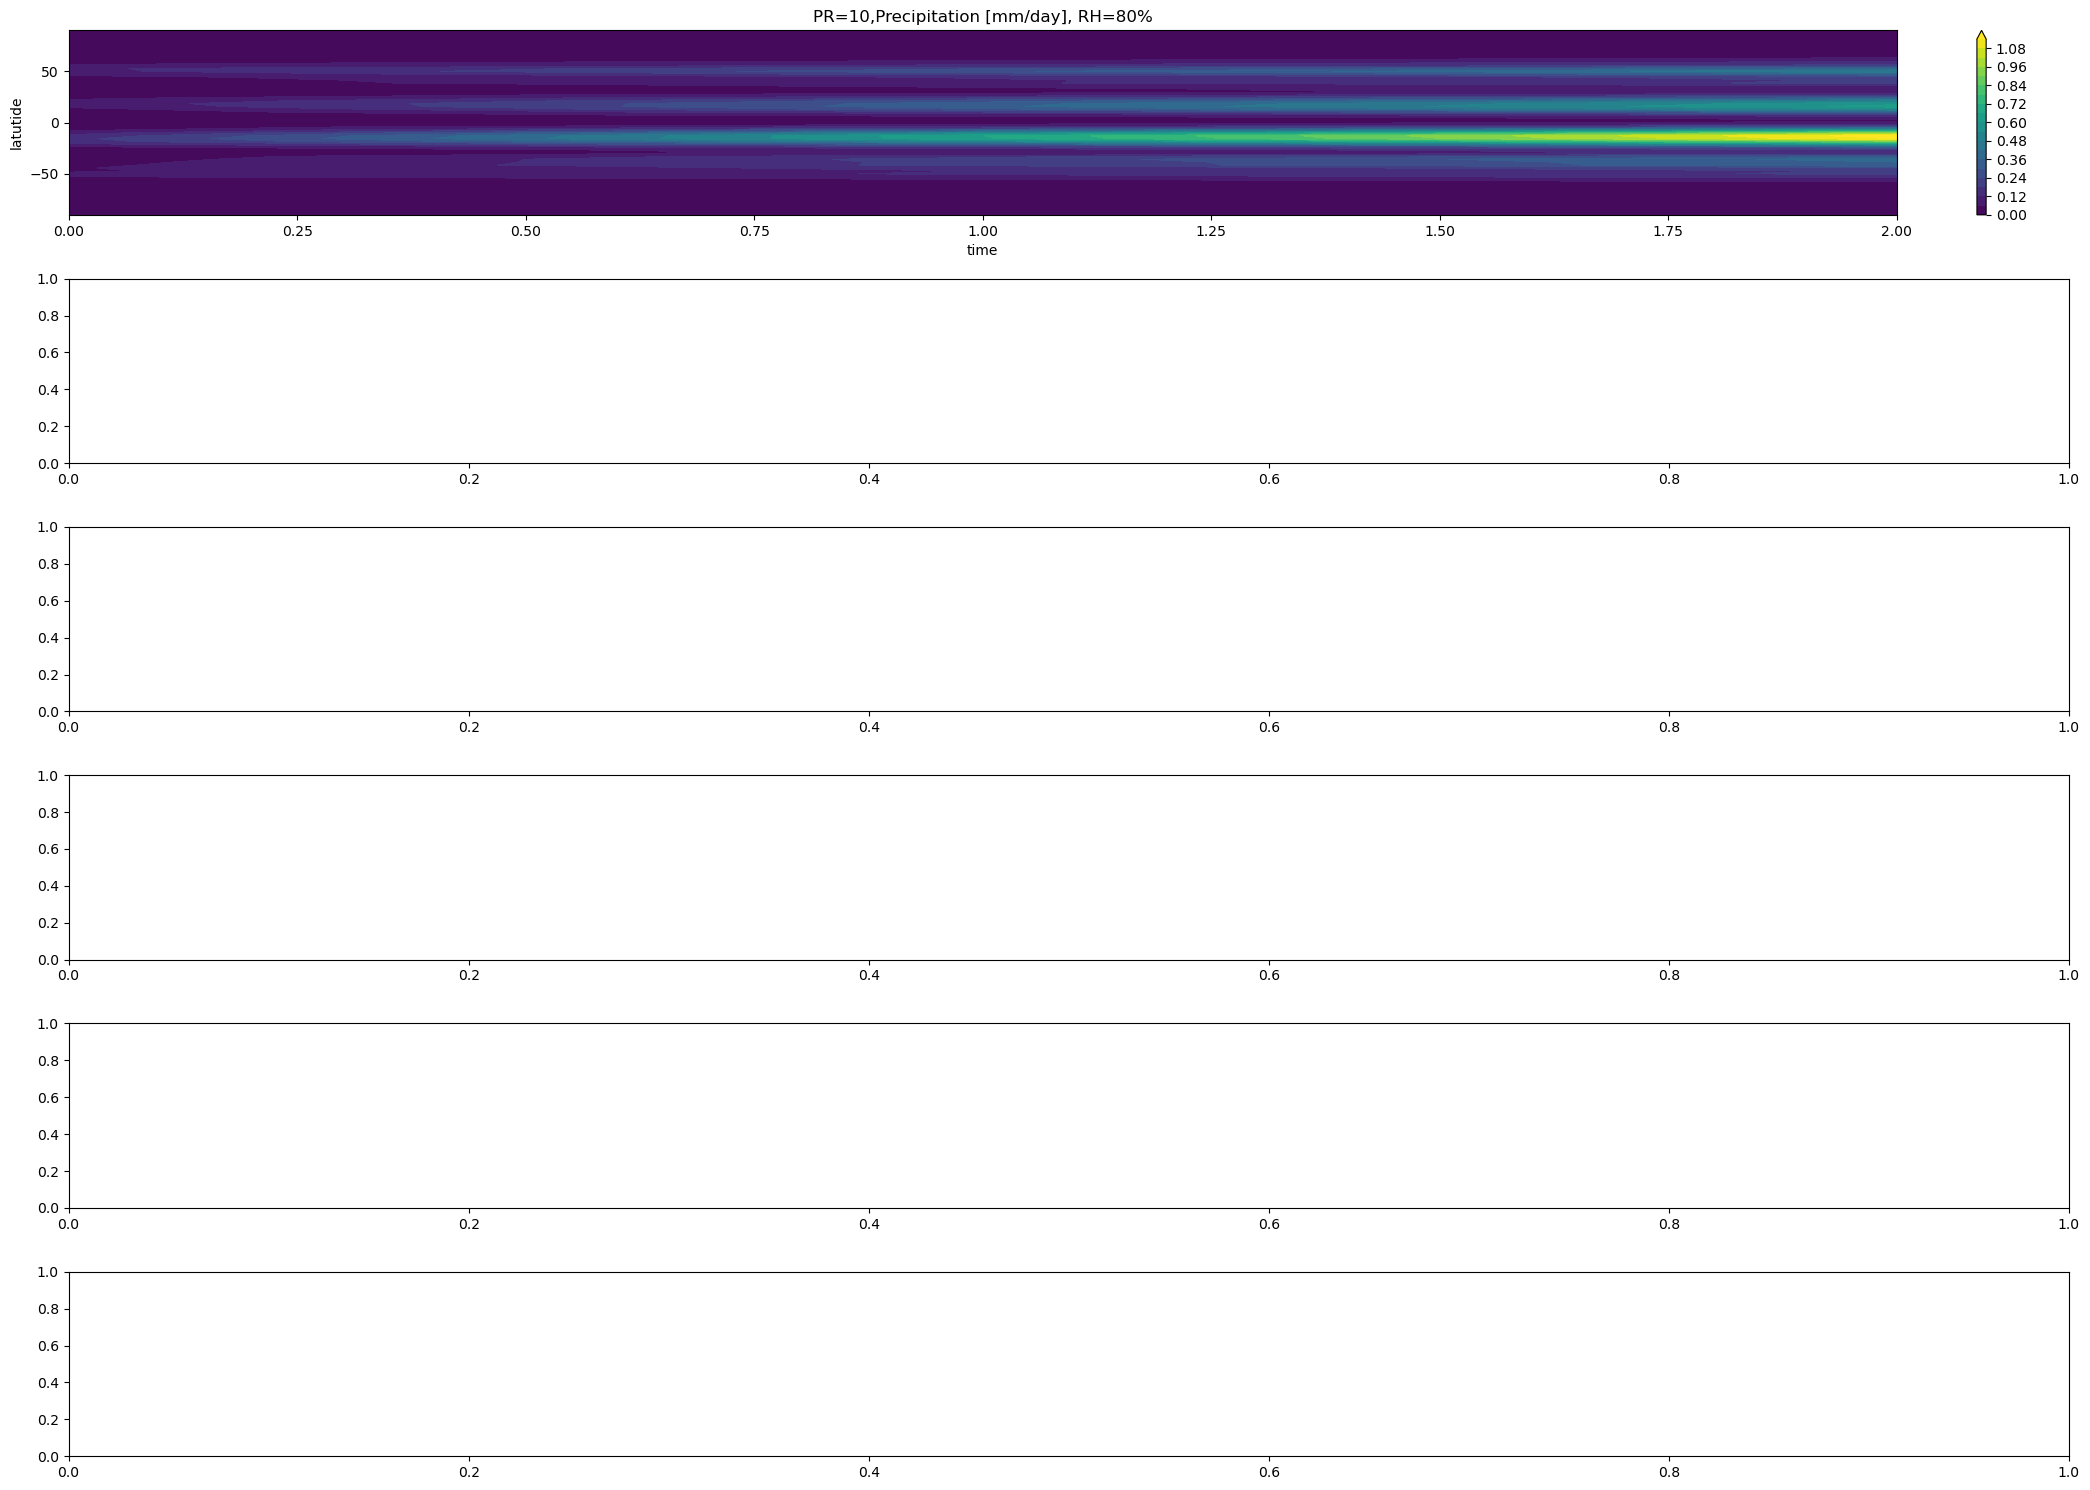

In [21]:
a = int(0)
fig, ax = plt.subplots(6, figsize=(21,15))
for pr in range(10,20,10):
    # file   = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
    # file = "t_init_RH80_PR10_1600day_test_all.dat"
    file = "test_final.dat"
    dycore = Dycore(file)
    # get_KE = dycore.cal_KE()   
    Prec   = dycore.cal_pre()
    # t_mean = dycore.cal_t()
    # t_mean2 = dycore.cal_t_last()
    
    
    # CS = ax[a].contourf(tt, yy, get_KE,levels=np.linspace(150,1050,7), extend="both")
    
    CS = ax[a].contourf(tt, yy, Prec[:,:] * int(pr),levels=21, extend="max")
        
    # CS = ax[a].contourf(tt, yy, t_mean, levels=21, extend="both")
    
    
    fig.colorbar(CS, orientation='vertical', ax=ax[a],fraction=0.046, pad=0.04)
    # ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
    
    ax[a].set_title(f"PR={pr},Precipitation [mm/day], RH=80%")
    # ax[a].set_title(f"T [K], PR={pr}")
    
    ax[a].set_xlabel("time")
    ax[a].set_ylabel("latutide")
    a += 1
    ### test
    
plt.tight_layout()
# plt.savefig("Check_Precipitation.png", dpi=300., bbox_inches='tight')
plt.show()



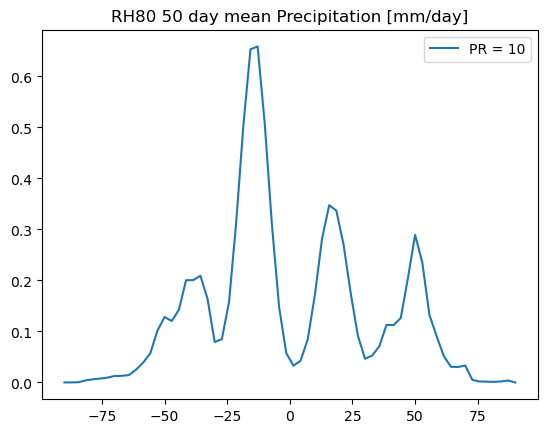

In [22]:
### cooridate
x  = np.linspace(-180,180,128)
y  = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy     = np.cos(yd)
cy[0]  = np.nan
cy[-1] = np.nan

plt.figure(dpi=100.)
plt.title("RH80 50 day mean Precipitation [mm/day]")

for pr in range(10,20,10):
    # file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    # file = f"PR{pr}_200day_test_ice_all.dat"
    # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
    dycore = Dycore(file)
    Prec   = dycore.cal_pre()
    Prec_mean  = np.nanmean(Prec[:,:], axis=0)
    plt.plot(y, Prec_mean * int(pr), label=f"PR = {pr}")
plt.legend()
plt.show()
# plt.figure(dpi=100.)

# for pr in range(10,15,5):
#     # file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
#     file = "100day_RH50_PR10_test_qp_equal_q_q_ref_t_eq_all.dat"
#     dycore = Dycore(file)
#     tq   = dycore.t_q
#     tq_mean  = np.nanmean(tq[0,:,:,:], axis=(0,2))
#     print(tq_mean.shape)
#     plt.plot(y, tq_mean , label=f"PR = {pr}")
# plt.legend()
# plt.show()

# Cal MultiPR

In [ ]:
# a = int(0)
# fig, ax = plt.subplots(6, figsize=(21,15))
# for pr in range(10,20,5):
#     # file   = f"800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
#     file = f"for_Checking_800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"
#     dycore = Dycore(file)
#     get_KE = dycore.cal_KE()   
#     Prec   = dycore.cal_pre()
#     t_mean = dycore.cal_t()
    
#     # CS = ax[a].contourf(tt, yy, get_KE,levels=np.linspace(150,1050,7), extend="both")
#     CS = ax[a].contourf(tt, yy, Prec * int(pr),levels=21, extend="both")
#     # CS = ax[a].contourf(tt, yy, t_mean, extend="both")
    
    
#     fig.colorbar(CS, orientation='vertical', ax=ax[a],fraction=0.046, pad=0.04)
#     # ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
    
#     ax[a].set_title(f"Precipitation [mm/day], PR={pr}")
#     # ax[a].set_title(f"T [K], PR={pr}")
    
#     ax[a].set_xlabel("time")
#     ax[a].set_ylabel("latutide")
#     a += 1
#     ### test
    
# plt.tight_layout()
# # plt.savefig("Check_Precipitation.png", dpi=300., bbox_inches='tight')
# plt.show()



In [ ]:
# a = int(0)
# fig, ax = plt.subplots(6, figsize=(21,15))
# for pr in range(0,30,5):
#     file   = f"800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
#     dycore = Dycore(file)
#     get_KE = dycore.cal_KE()   
#     # Prec   = dycore.cal_pre()
#     # t_mean = dycore.cal_t()
    
#     # CS = ax[a].contourf(tt, yy, get_KE,levels=np.linspace(150,1050,7), extend="both")
#     # CS = ax[a].contourf(tt, yy, Prec,levels=np.linspace(0,0.35,7), extend="both")
#     get_KE2 = np.nanmean(get_KE, axis=1)
#     CS = ax[a].plot(get_KE2)
    
    
#     # fig.colorbar(CS, orientation='vertical', ax=ax[a],fraction=0.046, pad=0.04)
#     # ax[a].set_title(f"Precipitation [mm/day], PR={pr}")
#     ax[a].set_title(f"T [K], PR={pr}")
    
#     ax[a].set_xlabel("time")
#     ax[a].set_ylabel("latutide")
#     a += 1
#     ### test
    
# plt.tight_layout()
# # plt.savefig("Check_Precipitation.png", dpi=300., bbox_inches='tight')
# plt.show()



# Cal MSE

In [ ]:
plt.figure(dpi=100.)
def cal_MSE():
    for pr in range(0,25,5):
        file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

        dycore = Dycore(file)
        u  = dycore.getVar("grid_u_c_xyzt")
        v  = dycore.getVar("grid_v_c_xyzt")
        t  = dycore.getVar("grid_t_c_xyzt")
        ps = dycore.getVar("grid_ps_xyzt")
        p  = dycore.getVar("grid_p_full_xyzt")
        qv = dycore.getVar("grid_tracers_c_xyz1t")

        p_mean = np.nanmean(p, axis=(0,2,3))
        sigma = p / ps
        sigma_mean = np.nanmean(sigma, axis=(0,3))
        sigma_onlyz = np.nanmean(sigma_mean, axis=1)
        Rd = 287
        cp = 1004
        g = 9.81
        Lv = 2.5E6
        ### cal z
        z = np.zeros(u.shape)
        for i in range(1,20-1):
            z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
        z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
        z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
        ###

        MSE = cp*t + g*z + Lv*qv

        final = np.nanmean(MSE[:-200,:,:,:], axis=(0,1,3))
        
        plt.plot(final/1000, label=f"PR = {pr}")
    plt.title("MSE[kJ/kg], 1400-1600day mean")
    # plt.yscale("log")
    # plt.gca().invert_yaxis()
    plt.legend()
    # plt.ylabel("hPa")
    
    plt.show()
    # return MSE, p_mean
gogo = cal_MSE()


In [ ]:
plt.figure(dpi=100.)
def cal_MSE_minus():
    for pr in [0]:
        file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

        dycore = Dycore(file)
        u  = dycore.getVar("grid_u_c_xyzt")
        v  = dycore.getVar("grid_v_c_xyzt")
        t  = dycore.getVar("grid_t_c_xyzt")
        ps = dycore.getVar("grid_ps_xyzt")
        p  = dycore.getVar("grid_p_full_xyzt")
        qv = dycore.getVar("grid_tracers_c_xyz1t")

        p_mean = np.nanmean(p, axis=(0,2,3))
        sigma = p / ps
        sigma_mean = np.nanmean(sigma, axis=(0,3))
        sigma_onlyz = np.nanmean(sigma_mean, axis=1)
        Rd = 287
        cp = 1004
        g = 9.81
        Lv = 2.5E6
        ### cal z
        z = np.zeros(u.shape)
        for i in range(1,20-1):
            z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
        z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
        z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
        ###

        MSE = cp*t + g*z + Lv*qv

        final0 = np.nanmean(MSE[:-200,:,:,:], axis=(0,1,3))
        
        plt.plot(final0-final0, label=f"PR = {pr}")
        
    for pr in range(5,25,5):
        file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

        dycore = Dycore(file)
        u  = dycore.getVar("grid_u_c_xyzt")
        v  = dycore.getVar("grid_v_c_xyzt")
        t  = dycore.getVar("grid_t_c_xyzt")
        ps = dycore.getVar("grid_ps_xyzt")
        p  = dycore.getVar("grid_p_full_xyzt")
        qv = dycore.getVar("grid_tracers_c_xyz1t")

        p_mean = np.nanmean(p, axis=(0,2,3))
        sigma = p / ps
        sigma_mean = np.nanmean(sigma, axis=(0,3))
        sigma_onlyz = np.nanmean(sigma_mean, axis=1)
        Rd = 287
        cp = 1004
        g = 9.81
        Lv = 2.5E6
        ### cal z
        z = np.zeros(u.shape)
        for i in range(1,20-1):
            z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
        z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
        z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
        ###

        MSE = cp*t + g*z + Lv*qv

        final = np.nanmean(MSE[:-200,:,:,:], axis=(0,1,3))
        
        plt.plot((final - final0)/1000, label=f"PR = {pr}")
    plt.title("MSE[kJ/kg] minus PR=0, 1400-1600day")
    # plt.yscale("log")
    # plt.gca().invert_yaxis()
    plt.legend()
    # plt.ylabel("hPa")
    
    plt.show()
    # return MSE, p_mean
gogo = cal_MSE_minus()


In [ ]:
### cooridate
x  = np.linspace(-180,180,128)
y  = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy     = np.cos(yd)
cy[0]  = np.nan
cy[-1] = np.nan

plt.figure(dpi=100.)
plt.title("Precipitation [g/m^2/day]")

for pr in range(0,25,5):
    file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    dycore = Dycore(file)
    Prec   = dycore.qv_diff
    Prec_mean  = np.nansum(Prec[-5:,:,:,:], axis=(0,1,3))
    plt.plot(Prec_mean , label=f"PR = {pr}")
plt.legend()
plt.show()

In [ ]:
# ### cooridate
# x  = np.linspace(-180,180,128)
# y  = np.linspace(-90,90,64)
# xd = np.deg2rad(x)
# yd = np.deg2rad(y)

# # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
# cy     = np.cos(yd)
# cy[0]  = np.nan
# cy[-1] = np.nan
# file  = "HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
# file2  = "800day_HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

# dycore = Dycore(file)

# def from_qv_to_p(file):
#     dycore = Dycore(file)
    
#     qv_diff = dycore.getVar("grid_tracers_diff_xyz1t")
#     t       = dycore.getVar("grid_t_c_xyzt")
    
#     qv_diff_sum = np.nansum(qv_diff[:,:,:,:], axis=(0,3))
#     qv_diff_sum_new = np.zeros(qv_diff_sum.shape)
#     pre = np.zeros((20,64))
#     rho             = np.zeros((20,64))
    
#     p_mean = np.nanmean(p, axis=(0,3))
#     t_mean = np.nanmean(t, axis=(0,3))
    
#     z_mean = np.nanmean(z, axis=(0,3))
    
#     for i in range(1,64-1):
#         qv_diff_sum_new[:,i] = qv_diff_sum[:,i] * cy[i]**0.5
#     for i in range(1,64-1):
#         rho[:,i] = p_mean[:,i] / 287 / t_mean[:,i] 

#     for i in range(64):
#         pre[:,i] = qv_diff_sum_new[:,i] * rho[:,i]
#     pre_final = np.nansum(pre,axis=0)
#     return pre_final

# pre = from_qv_to_p(file)
# pre2 = from_qv_to_p(file2)

# plt.figure()
# plt.plot(pre)
# plt.plot(pre2)
# plt.title("Precipitation [g/m^2/day]")
# plt.show()

# Cal qv

In [23]:
# file = "day50_hope_test_all.dat"
# file = "test_all.dat"

dycore = Dycore(file)


In [24]:
v_o = dycore.v
w_o = -dycore.omega
yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2
u = dycore.u
v = dycore.v

p = dycore.p
ps = dycore.ps
qv = dycore.qv
qv_diff = dycore.qv_diff
t = dycore.t

Lv = 2.5 * 10**6
Rv = 461
# grid_t_eq_ref = dycore.grid_t_eq_ref_xyzt
# grid_tracers_t_eq_ref = (0.622 * (611.12 * np.exp(Lv / Rv * (1. / 273.15 - 1. / grid_t_eq_ref)) )) / (p - 0.378 * (611.12 * np.exp(Lv / Rv * (1. / 273.15 - 1. / grid_t_eq_ref)) )) ######### 10/30 cc equation should use grid_t
teq = dycore.t_eq

w = np.nanmean(w_o[:], axis=(0,3))
v = np.nanmean(v_o[:], axis=(0,3))

### Cal T and Teq

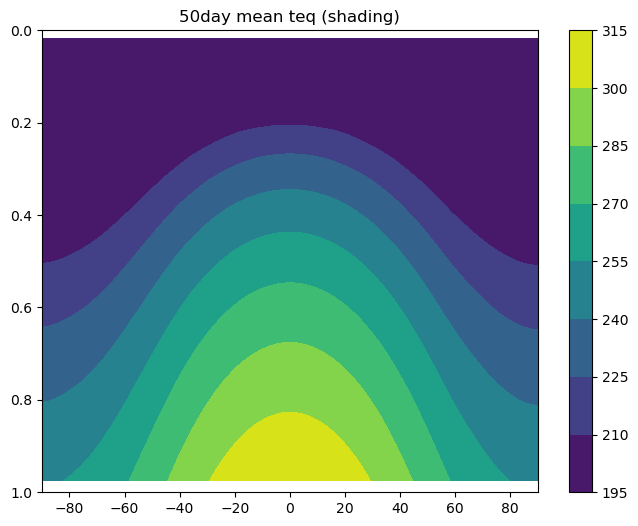

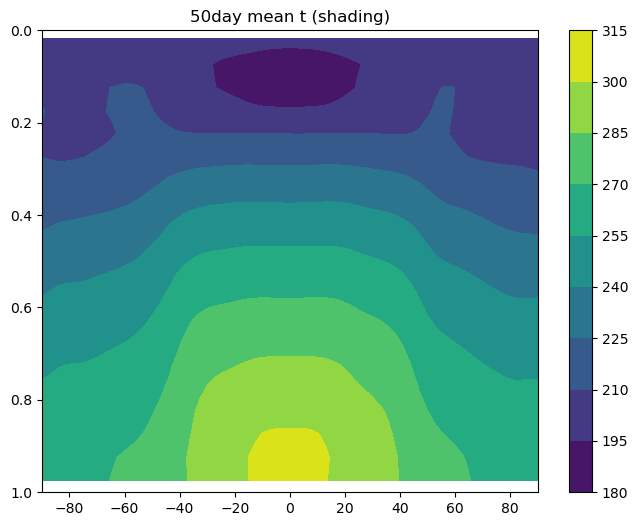

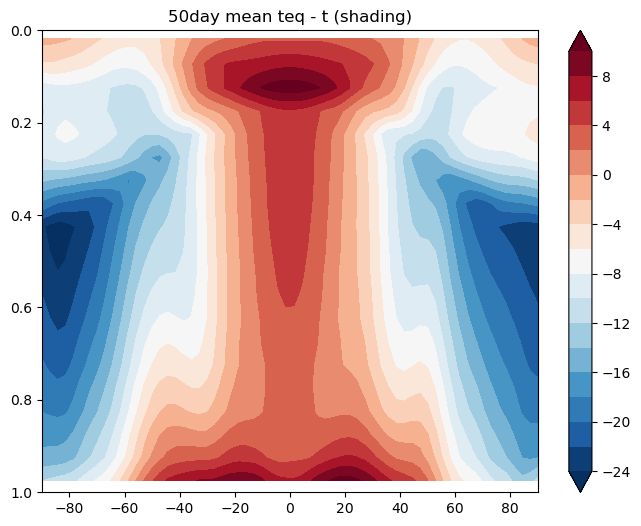

In [101]:
plt.figure(figsize=(8,6),dpi=100.)
teq_mean = np.nanmean(teq, axis=(0,3))
CS = plt.contourf(yy, sigma_mean2, teq_mean)

plt.colorbar(CS)
plt.ylim([1,0])
plt.title("50day mean teq (shading)")
plt.show()
##############################################
plt.figure(figsize=(8,6),dpi=100.)
t_mean = np.nanmean(t, axis=(0,3))
CS = plt.contourf(yy, sigma_mean2, t_mean)

plt.colorbar(CS)
plt.ylim([1,0])
plt.title("50day mean t (shading)")
plt.show()
##############################################
plt.figure(figsize=(8,6),dpi=100.)
t_mean = np.nanmean(t, axis=(0,3))
CS = plt.contourf(yy, sigma_mean2, teq_mean - t_mean, levels=21, cmap="RdBu_r", extend="both")

plt.colorbar(CS)
plt.ylim([1,0])
plt.title("50day mean teq - t (shading)")
plt.show()

### Cal qv, qv_diff, and meridional circulation

In [25]:
### cooridate
x  = np.linspace(-180,180,128)
y  = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy     = np.cos(yd)
cy[0]  = np.nan
cy[-1] = np.nan

rho_0     = np.zeros((20,64))
rho_0_all = np.zeros(u.shape)
for i in range(0,20):
    rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
    rho_0_all[:,i,:,:] = p[:,i,:,:] / ps[:,0,:,:]  
# phi
a = 6.37122e6
lat   = np.linspace(-90, 90, 64)
phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
cphi  = np.cos(phi) 
acphi = a * cphi

psi_w1 = np.zeros((20,64))
psi_w2 = np.zeros((20,64))

psi_w1[:,0] = 0
for ilat in range(1,64-1):
    dlat = phi[:,ilat] - phi[:,ilat-1]       
    psi_w1[:,ilat] =  psi_w1[:,ilat-1] + (dlat * (w)[:,ilat])
    # print(psi_w1[:,ilat])

psi_w2[:,64-1] = 0    
for jlat in range(1,64-1):
    ilat = 64 - 1 - jlat
    dlat = phi[:,ilat] - phi[:,ilat+1]           
    psi_w2[:,ilat] =  psi_w2[:,ilat+1] + (dlat * (w)[:,ilat])

psi_w = 0.5*(psi_w1 + psi_w2)
###
qv_mean = np.nanmean(qv[:,:,:,:], axis=(0,3))
###



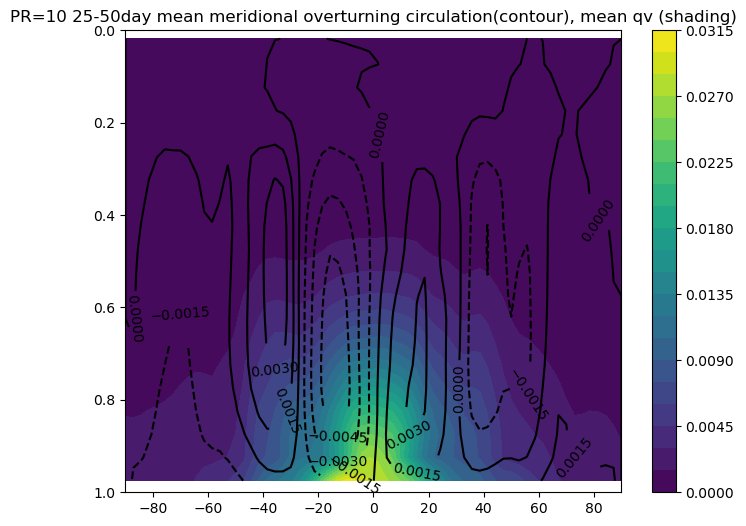

In [26]:
for i in range(10,20,10):
    pr = i
    # file = f"PR{pr}_200day_test_ice_all.dat"
    # file = "day20_hope_test_all.dat"
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    qv = dycore.qv
    qv_mean = np.nanmean(qv[:,:,:,:], axis=(0,3))



    plt.figure(figsize=(8,6),dpi=100.)
    CS = plt.contourf(yy, sigma_mean2, qv_mean, levels=21)

    CT = plt.contour(yy, sigma_mean2, psi_w, colors='k')

    plt.colorbar(CS)

    plt.clabel(CT)

    plt.ylim([1,0])
    plt.title(f"PR={pr} 25-50day mean meridional overturning circulation(contour), mean qv (shading)")
    plt.show()

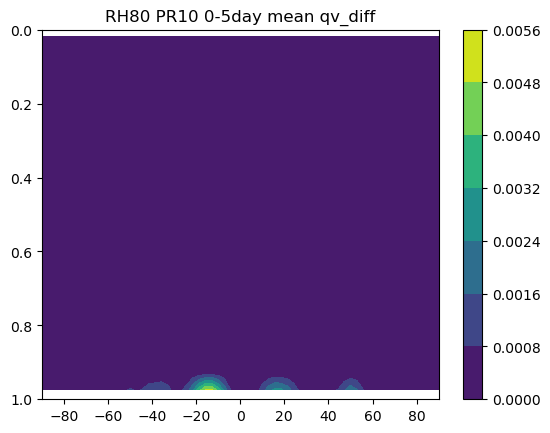

In [27]:
for i in range(10,20,10):
    pr = i
    # file = f"PR{pr}_200day_test_ice_all.dat"
    # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
    # file = "day10_hope_test_all.dat"
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    qv_diff = dycore.qv_diff

    plt.figure(dpi=100.)
    qv_diff_mean = np.nanmean(qv_diff[:,:,:,:], axis=(0,3))
    # qv_diff_mean = np.nanmean(qv_diff[-100:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, qv_diff_mean)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day mean qv_diff")

    plt.ylim([1,0])
    plt.show()


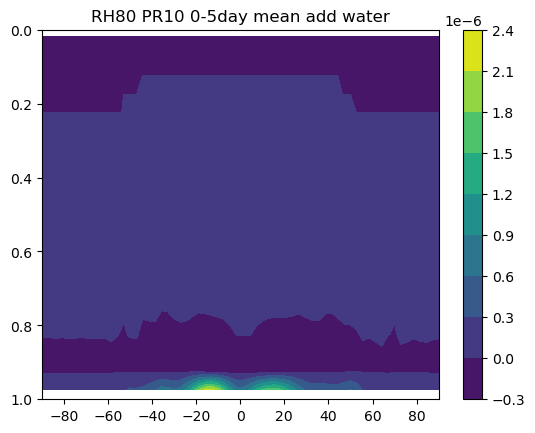

In [28]:

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    add_water = dycore.add_water

    plt.figure(dpi=100.)
    add_water_mean = np.nanmean(add_water[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, add_water_mean)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day mean add water")

    plt.ylim([1,0])
    plt.show()


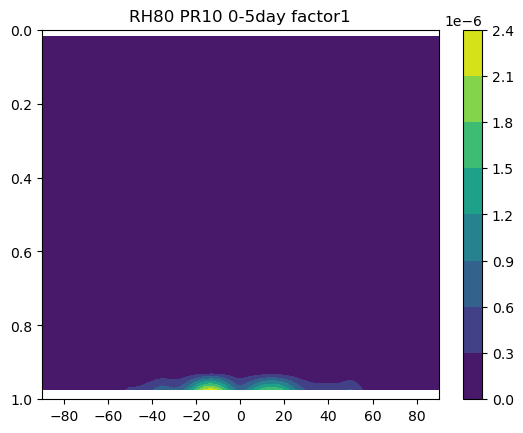

In [29]:

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    factor1 = dycore.factor1

    plt.figure(dpi=100.)
    factor1_mean = np.nanmean(factor1[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor1_mean)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day factor1")

    plt.ylim([1,0])
    plt.show()


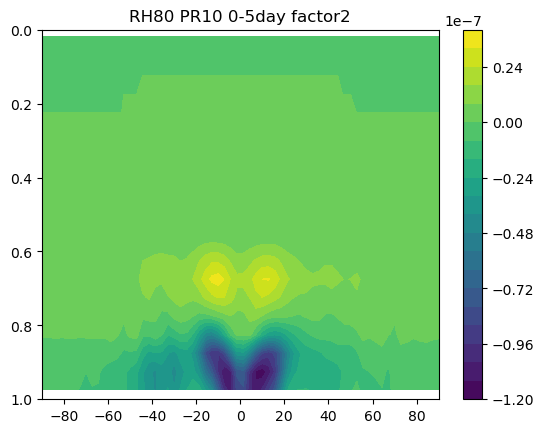

In [30]:

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    factor2 = dycore.factor2

    plt.figure(dpi=100.)
    factor2_mean = np.nanmean(factor2[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor2_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day factor2")

    plt.ylim([1,0])
    plt.show()


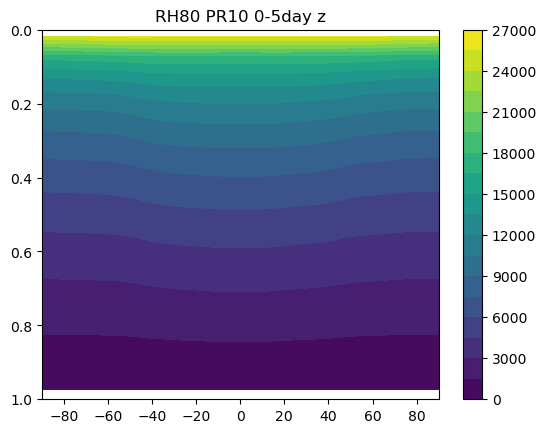

In [14]:

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    z = dycore.z

    plt.figure(dpi=100.)
    z_mean = np.nanmean(z[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, z_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day z")

    plt.ylim([1,0])
    plt.show()


In [69]:
ps = dycore.ps
p = dycore.p
p_half = dycore.p_half

diff = ps[0,0,0,0] -p_half[0,20,0,0]
print(ps.shape)
print(p.shape)

print(diff.max())


(2, 1, 64, 128)
(2, 20, 64, 128)
0.0


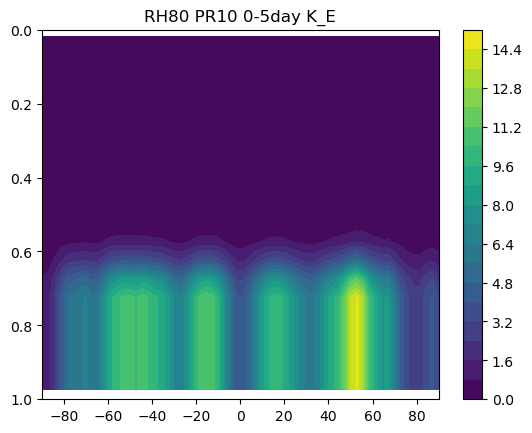

In [70]:

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    K_E = dycore.K_E

    plt.figure(dpi=100.)
    K_E_mean = np.nanmean(K_E[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, K_E_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day K_E")

    plt.ylim([1,0])
    plt.show()


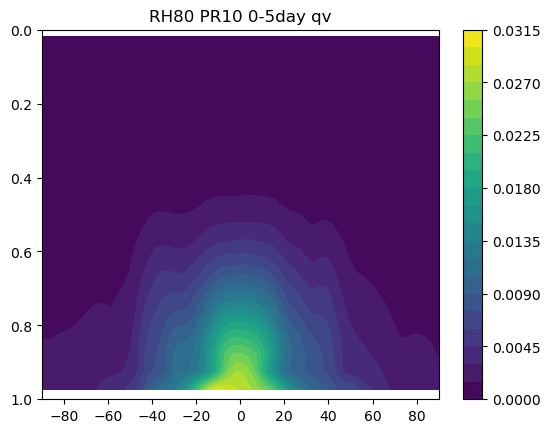

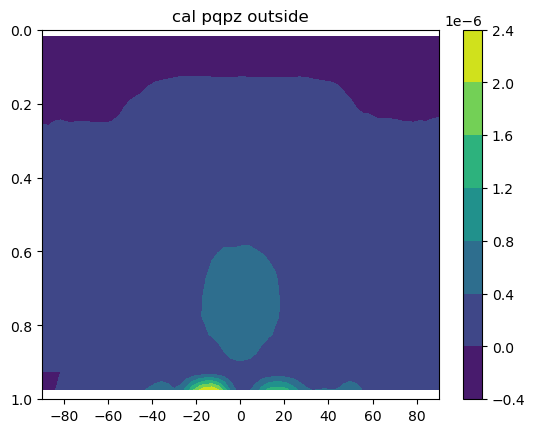

In [47]:
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    qv = dycore.qv

    plt.figure(dpi=100.)
    qv_mean = np.nanmean(qv[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, qv_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day qv")

    plt.ylim([1,0])
    plt.show()

pqpz_new = np.zeros(((2,20,64,128)))
for i in range(0,18):
    pqpz_new[:,i,:,:] = (qv[:,i+1,:,:] - qv[:,i-1,:,:]) / (p[:,i+1,:,:] - p[:,i-1,:,:])
pqpz_new[:,0,:,:] = (qv[:,1,:,:] - qv[:,0,:,:]) / (p[:,1,:,:] - p[:,0,:,:])
# pqpz_new[:,19,:,:] = (qv[:,19,:,:] - qv[:,18,:,:]) / (p[:,19,:,:] - p[:,18,:,:])


pqpz_new_mean = np.nanmean(pqpz_new, axis=(0,3))


plt.figure(dpi=100.)
plt.contourf(yy, sigma_mean2, pqpz_new_mean)
plt.colorbar()
plt.ylim([1,0])
plt.title("cal pqpz outside")
plt.show()

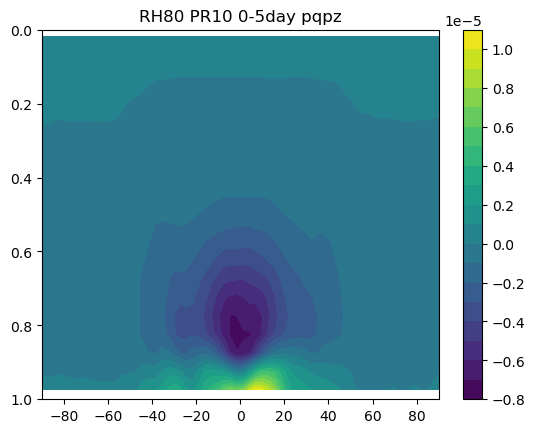

In [32]:

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    pqpz = dycore.pqpz

    plt.figure(dpi=100.)
    pqpz_mean = np.nanmean(pqpz[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, pqpz_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day pqpz")

    plt.ylim([1,0])
    plt.show()


In [73]:
u, v = dycore.u, dycore.v
surface = (u[:,:,:,:]**2 + v[:,:,:,:]**2)**0.5
print(u.shape)
print(v.shape)

(2, 20, 64, 128)
(2, 20, 64, 128)


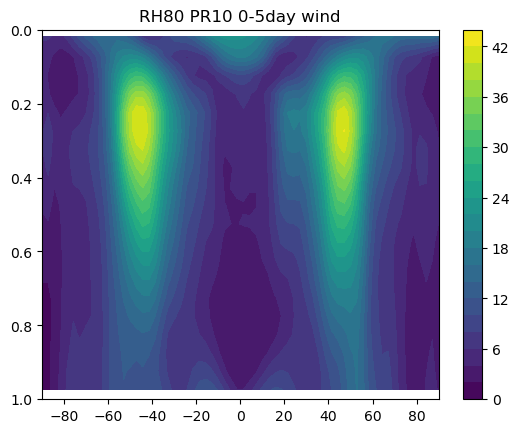

In [74]:

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    

    plt.figure(dpi=100.)
    surface_mean = np.nanmean(surface[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, surface_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day wind")

    plt.ylim([1,0])
    plt.show()


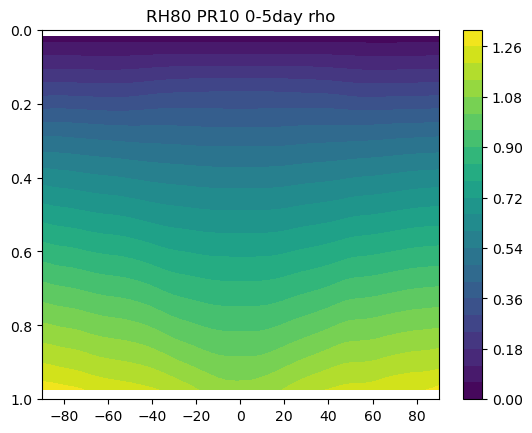

In [66]:

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    rho = dycore.rho

    plt.figure(dpi=100.)
    rho_mean = np.nanmean(rho[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, rho_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day rho")

    plt.ylim([1,0])
    plt.show()


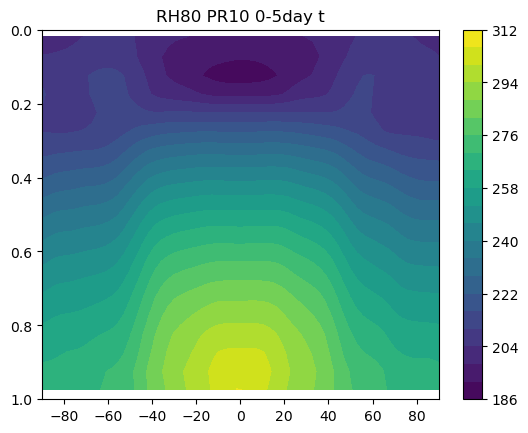

In [75]:
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    t = dycore.t

    plt.figure(dpi=100.)
    t_mean = np.nanmean(t[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, t_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day t")

    plt.ylim([1,0])
    plt.show()